# Autocodificadores

In [1]:
from __future__ import division, print_function, unicode_literals
import sys

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_figs(lst, figsize = 12):
    f, axes = plt.subplots(1, len(lst), figsize = (figsize, figsize*len(lst)))
    for i, a in enumerate(axes):
        a.matshow(lst[i], cmap = 'gray', interpolation='nearest')
        a.set(aspect='equal')
        a.axis('off')

Redes auto-codificadoras são aquelas que procuram reproduzir sua entrada na saída. Em geral, elas são formadas por duas redes simétricas, o codificador e o decodificador. A ideia do treino é reduzir o erro de reconstrução. Ou seja, a saída do decodificador deve ser o mais parecido possível com a entrada do codificador.

<img src="images/stacked-autoencoder.png" alt="Stacked AEnc" style="width: 300px;"/>

Note que o critério de otimização por minimizar o erro de reconstrução dispensa a necessidade de supervisão (uma vez que o erro é estimado diretamente da comparação da entrada com a saída). Logo, estes métodos são _não supervisionados_. Estas redes são capazes de aprender códigos baseados em atributos que representam bem a coleção completa dos dados. Ao aprenderem boas representações baseadas no que foi visto na coleção, são adequadas para encontrar anomalias (qualquer entrada que ela não consegue reproduzir bem, depois de treinada, é possívelmente anômala).

Estas redes são historicamente importantes em _deep learning_ ao tornaram possível o treino das primeiras redes profundas na segunda metade dos anos 2000. As redes treinadas de forma não supervisionada eram usadas então como ponto inicial de redes profundas, na técnica conhecida como _pré-treino_.

### Aucodificadores empilhados

A rede descrita na introdução é chamada autocodificador empilhado, pelo fato de aprender representações sob pilhas de camadas. A seguir, vamos implementar um autocodificador empilhado em tensorflow, para codificar a MNIST.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


A rede que vamos implementar tem a seguinte arquitetura:

<img src="images/stacked-autoencoder.png" alt="Stacked AEnc" style="width: 300px;"/>

In [5]:
reset_graph()
from functools import partial

n_inputs = 28*28
n_h1 = 300
n_h2 = 150
n_h3 = n_h1
n_outputs = n_inputs
learning_rate = 0.001
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
# He inititializtion
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                        activation = tf.nn.elu,
                        kernel_initializer = he_init,
                        kernel_regularizer = l2_regularizer)
h1 = my_dense_layer(X, n_h1)
h2 = my_dense_layer(h1, n_h2)
h3 = my_dense_layer(h2, n_h3)
outputs = my_dense_layer(h3, n_outputs, activation = None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)  
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [6]:
n_epochs = 5
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for i in range(n_batches):
            print("\r{}%".format(10*i // n_batches), end = "")
            sys.stdout.flush()
            X_b, y_b = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict = {X: X_b})
        loss_train = reconstruction_loss.eval(feed_dict = {X: X_b})
        print("\r{}".format(e), "MSE tr:", loss_train)
        saver.save(s, "/tmp/new.ckpt")

0 MSE tr: 0.0164052
1 MSE tr: 0.0101934
2 MSE tr: 0.00949155
3 MSE tr: 0.00922882
4 MSE tr: 0.00962562


#### Reconstruindo entrada

Uma forma de avaliar a qualidade do nosso auto-codificador, é usá-lo para reconstruir a entrada.

In [7]:
import random

def show_reconstructed_digits(X_test, outputs, 
                              model_path = None):
    n_test_digits = len(X_test)
    with tf.Session() as s:
        if model_path:
            saver.restore(s, model_path)
        X_recons = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for i in range(n_test_digits):
        plt.subplot(n_test_digits, 2, i * 2 + 1)
        plot_image(X_test[i])
        plt.subplot(n_test_digits, 2, i * 2 + 2)
        plot_image(X_recons[i])

INFO:tensorflow:Restoring parameters from /tmp/new.ckpt


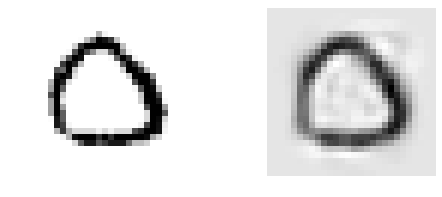

In [8]:
idx = random.randint(0, mnist.test.num_examples)
show_reconstructed_digits(mnist.test.images[idx:idx+1],
                   outputs, "/tmp/new.ckpt")

#### Verificando casos anômalos

Uma aplicação interessante é a checagem de outliers.

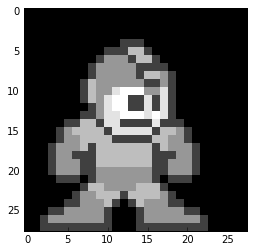

In [9]:
from PIL import Image
im = Image.open('images/warrior.png') 
image = np.asarray(im) 
image_grayscale = image.mean(axis=2).astype(np.float32)
image_grayscale /= 255. # normalize between 0 and 1
plt.imshow(image_grayscale, cmap = 'gray', interpolation = 'nearest')

INFO:tensorflow:Restoring parameters from /tmp/new.ckpt


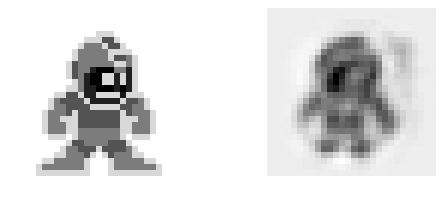

In [10]:
warrior = image_grayscale.reshape(1, 28*28)
show_reconstructed_digits(warrior, outputs, "/tmp/new.ckpt")

In [11]:
def show_recloss(recloss, figs):
    fig = plt.figure()
    axplot = plt.barh(range(len(figs)), rec_loss, align='center')
    for k in range(len(figs)):
        aximg = fig.add_axes([0.01, 0.185 + 0.111*k, 0.10, 0.10])
        aximg.imshow(figs[k], cmap = 'gray', interpolation='nearest')
        aximg.set_xticks([])
        aximg.set_yticks([])

INFO:tensorflow:Restoring parameters from /tmp/new.ckpt


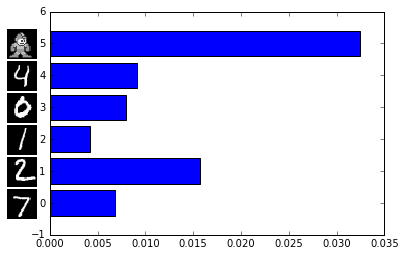

In [12]:
numfigs = 5
X_test = mnist.test.images
with tf.Session() as s:
    saver.restore(s, "/tmp/new.ckpt")
    rec_loss = [reconstruction_loss.eval(feed_dict = 
                                         {X: X_test[i].reshape(1, 784)}) 
                for i in range(numfigs)]
    rec_loss += [reconstruction_loss.eval(feed_dict = {X: warrior})]
figs = [mnist.test.images[i].reshape(28,28) 
        for i in range(numfigs)] + [image_grayscale]
show_recloss(rec_loss, figs)

#### Observando espaço latente (o espaço de emdeddings)

In [18]:
# Ploting coded test images using TSNE
from time import time
from matplotlib import offsetbox
from sklearn import manifold

# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)
        
# t-SNE embedding of the digits dataset
def plot_tsne(XX, yy):
    print("Computing t-SNE embedding")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    t0 = time()
    X_tsne = tsne.fit_transform(XX)
    plot_embedding(X_tsne, yy,
                   "t-SNE %d embedding of the %d-D digits (time %.2fs)" %
                   (XX.shape[0], XX.shape[1], time() - t0))

INFO:tensorflow:Restoring parameters from /tmp/new.ckpt
Computing t-SNE embedding


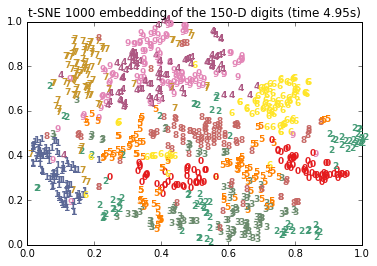

In [14]:
cases_to_plot = 1000
idxs = np.random.permutation(mnist.test.num_examples)[:cases_to_plot]
X_test = mnist.test.images[idxs]
with tf.Session() as s:
    saver.restore(s, "/tmp/new.ckpt")
    codings_val = h2.eval(feed_dict = {X: X_test})
plot_tsne(codings_val, mnist.test.labels[idxs])

### Aucodificadores empilhados com pesos transpostos

Uma maneira de simplificar o modelo é garantindo que os pesos que serão aprendidos em camadas simétricas são os mesmos (transpostos). Isso é possível se a rede for perfeitamente simétrica. Neste caso, há menos parâmetros para aprender e, portanto, menos problemas com _overfitting_.

In [15]:
reset_graph()

n_inputs = 28 * 28
n_h1 = 300
n_h2 = 150  # codings
n_h3 = n_h1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [16]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_h1])
weights2_init = initializer([n_h1, n_h2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
# transposed weights (tied!)
weights3 = tf.transpose(weights2, name="weights3")  
weights4 = tf.transpose(weights1, name="weights4")  

biases1 = tf.Variable(tf.zeros(n_h1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_h2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_h3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

h1 = activation(tf.matmul(X, weights1) + biases1)
h2 = activation(tf.matmul(h1, weights2) + biases2)
h3 = activation(tf.matmul(h2, weights3) + biases3)
outputs = tf.matmul(h3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [17]:
n_epochs = 5
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(e), "MSE tr:", loss_train)
        saver.save(s, "/tmp/my_model_tying_weights.ckpt")

0 MSE tr: 0.0150669
19% MSE tr: 0.0164887
2 MSE tr: 0.0173759
3 MSE tr: 0.0168783
4 MSE tr: 0.0155877


INFO:tensorflow:Restoring parameters from /tmp/my_model_tying_weights.ckpt


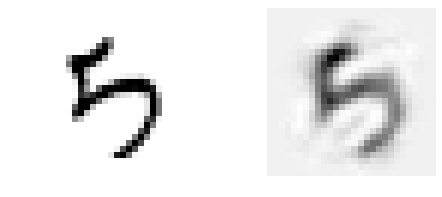

In [19]:
idx = random.randint(0, mnist.test.num_examples)
show_reconstructed_digits(mnist.test.images[idx:idx+1],
                   outputs, "/tmp/my_model_tying_weights.ckpt")

### Aucodificadores empilhados treinados camada-a-camada

Redes auto-codificadoras com várias camadas podem ser treinadas camada-a-camada. A figura abaixo (do artigo "Deep networks for motor control functions") ilustra a construção de auto-codificador usando esta estratégia. 

![](images/stacked-auto-encoders.png)

Na figura, observamos que a rede é primeiro treinada para prever o código $V$ que possibilita mapear $Y$ para $\hat{Y}$. Uma vez que a saída do decodificador ($\hat{Y}$) aproxima a entrada do codificador, a camada de código é então usada como entrada de um novo codificador ($V$) que gera um código $W$ com o intuito de prever $\hat{V}$. Ao fazer isso múltiplas vezes, se obtem uma rede como a terceira ilustrada na figura (A) com camadas $Y$, $V$, $W$ e código $Z$. As metades da rede final  podem ser usadas como codificadoras ou decodificadoras (rede B). 

Abaixo, vamos usar esta estratégia de construção no tensorflow, usando múltiplos grafos. Note que a função `train_autoencoder` treina um autocodificador raso de uma única camada escondida:

In [20]:
import numpy.random as rnd

reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    g = tf.Graph()
    with g.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=g) as s:
        init.run()
        for e in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for i in range(n_batches):
                print("\r{}%".format(100 * i // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                s.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(e), "MSE tr:", loss_train)
        params = dict([(var.name, var.eval()) 
                       for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return (hidden_val, 
                params["hidden/kernel:0"], 
                params["hidden/bias:0"], 
                params["outputs/kernel:0"], 
                params["outputs/bias:0"])

Agora vamos treinar 2 auto-codificadores: o 1o será treinado nos dados de treino e o 2o na saída da camada escondida do 1o.

In [21]:
h1_out, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, 
                                           n_neurons = 300, n_epochs = 4, 
                                           batch_size = 150)

0 MSE tr: 0.0185179
1 MSE tr: 0.0186827
2 MSE tr: 0.0184677
3 MSE tr: 0.0192318


In [22]:
_, W2, b2, W3, b3 = train_autoencoder(h1_out, 
                                      n_neurons = 150, n_epochs = 4, 
                                      batch_size = 150)

0 MSE tr: 0.00410999
1 MSE tr: 0.00461447
2 MSE tr: 0.00455272
3 MSE tr: 0.00431479


In [29]:
reset_graph()
n_inputs = 28*28

X = tf.placeholder(tf.float32, shape = (None, n_inputs))
h1 = tf.nn.elu(tf.matmul(X, W1) + b1)
h2 = tf.nn.elu(tf.matmul(h1, W2) + b2)
h3 = tf.nn.elu(tf.matmul(h2, W3) + b3)
outputs = tf.matmul(h3, W4) + b4

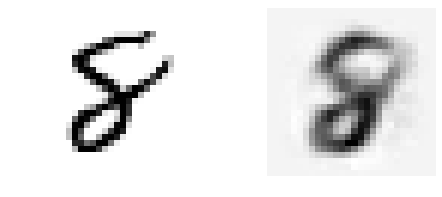

In [30]:
idx = random.randint(0, mnist.test.num_examples)
show_reconstructed_digits(mnist.test.images[idx:idx+1], outputs)

### Aucodificadores empilhados robustos a ruído (Stacked denoising auto-encoders)

Da mesma forma que fizemos com CNNs, podemos melhorar a robustez do nosso modelo, fornecendo entradas com ruído. Desta forma, o codificador deve aprender padrões independente do ruído no sinal de entrada. Estes modelos são conhecidos como _stacked denoising autoencoders_.

Para implementá-los em TF, temos duas opções comuns: (1) introduzir erro gaussiano na entrada; (2) fazer _droput_ na entrada.

#### SDAe com erro Gaussiano

In [42]:
reset_graph()

n_inputs = 28 * 28
n_h1 = 300
n_h2 = 150  # codings
n_h3 = n_h1
n_outputs = n_inputs

learning_rate = 0.01

In [43]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

my_dense_layer = partial(tf.layers.dense,
                        activation = tf.nn.relu)
h1 = my_dense_layer(X_noisy, n_h1)
h2 = my_dense_layer(h1, n_h2)
h3 = my_dense_layer(h2, n_h3)
outputs = my_dense_layer(h3, n_outputs, activation = None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 10
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(e), "MSE tr:", loss_train)
        saver.save(s, "/tmp/my_model_stacked_denoising_gaussian.ckpt")

0 MSE tr: 0.0447354
1 MSE tr: 0.0432453
2 MSE tr: 0.0421376
3 MSE tr: 0.0417833
4 MSE tr: 0.0424707
5 MSE tr: 0.0398407
6 MSE tr: 0.0413982
7 MSE tr: 0.0418401
89% MSE tr: 0.0394467
9 MSE tr: 0.0401225


INFO:tensorflow:Restoring parameters from /tmp/my_model_stacked_denoising_gaussian.ckpt


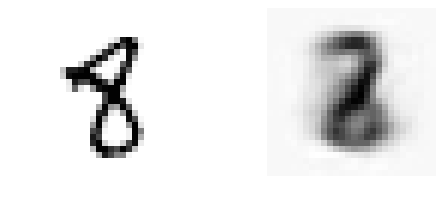

In [40]:
idx = random.randint(0, mnist.test.num_examples)
show_reconstructed_digits(mnist.test.images[idx:idx+1],
                   outputs, "/tmp/my_model_stacked_denoising_gaussian.ckpt")

#### SDAe com Dropout

In [46]:
reset_graph()

n_inputs = 28 * 28
n_h1 = 300
n_h2 = 150  # codings
n_h3 = n_h1
n_outputs = n_inputs

learning_rate = 0.01

In [47]:
dropout_rate = 0.3
training = tf.placeholder_with_default(False, shape=(), name='training')

# X is dropouted
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

h1 = tf.layers.dense(X_drop, n_h1, activation=tf.nn.relu, name="h1")
h2 = tf.layers.dense(h1, n_h2, activation=tf.nn.relu, name="h2")                            
h3 = tf.layers.dense(h2, n_h3, activation=tf.nn.relu, name="h3")                            
outputs = tf.layers.dense(h3, n_outputs, name="outputs")        

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) 

In [48]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [49]:
n_epochs = 10
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(e), "MSE tr:", loss_train)
        saver.save(s, "/tmp/my_model_stacked_denoising_dropout.ckpt")

0 MSE tr: 0.0321837
1 MSE tr: 0.031404
2 MSE tr: 0.0302707
3 MSE tr: 0.0303553
4 MSE tr: 0.0280997
5 MSE tr: 0.0287914
6 MSE tr: 0.0288815
7 MSE tr: 0.0283376
89% MSE tr: 0.0264546
9 MSE tr: 0.0292399


INFO:tensorflow:Restoring parameters from /tmp/my_model_stacked_denoising_dropout.ckpt


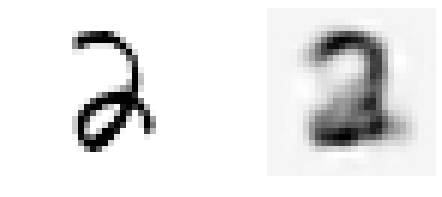

In [53]:
idx = random.randint(0, mnist.test.num_examples)
show_reconstructed_digits(mnist.test.images[idx:idx+1],
                   outputs, "/tmp/my_model_stacked_denoising_dropout.ckpt")

### Aucodificadores esparsos

Outra forma de melhorar a representação de um auto-codificador é aumentando a esparsidade do modelo. A ideia é que se a rede puder usar apenas um pequeno número de unidades por vez, ela acaba por induzir estas unidades a observarem padrões mais significativos, ou seja, constituirem atributos mais representativos dos dados na coleção.

Como vimos antes, uma forma de induzir esparsidade é usar a norma $L_1$. Uma alternativa é usar a divergência de Kullback-Leibler ($D_{KL}$). Uma razão para optar pela $D_{KL}$ é que ela fornece gradientes maiores. A ideia em usá-la é medir a divergência entre a probabilidade de esparsidade desejada $p$ (ou seja, a probabilidade de ativação dos neurônios) e a probabilidade $q$ de ativações observadas (estimada pela média de ativações reais durante o _batch_, que não pode ser tão pequeno, para que as estimativas sejam confiáveis). Isto pode ser calculado como:

$$D_{KL}(p || q) = p \log \frac{p}{q} + (1 − p) \log \frac{1 − p}{1- q}$$

A perda $D_{KL}$ é então agregada para todos os neurônios e adicionada à perda de reconstrução. A perda $D_{KL}$ ainda é ponderada por um coeficiente de regularização, como visto a seguir.

In [4]:
def DKLnp(p, q):
    # Kullback Leibler divergence
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


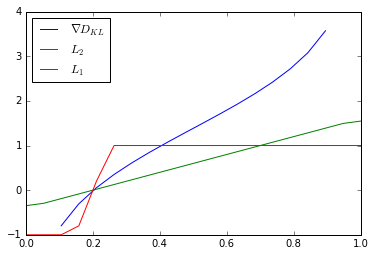

In [26]:
ps = np.linspace(0, 1, 20)
l1 = [np.abs(p-0.2) for p in ps]
l2 = [(p-0.2)**2 for p in ps]
dkl = [DKLnp(p, 0.2) for p in ps]

plt.plot(ps, np.gradient(dkl, ps), label = r'$\nabla D_{KL}$')
plt.plot(ps, np.gradient(l2, ps), label = r'$L_2$')
plt.plot(ps, np.gradient(l1, ps), label = r'$L_1$')
plt.legend(loc = 'top left')

In [54]:
reset_graph()

n_inputs = 28 * 28
n_h1 = 1000  # sparse codings
n_outputs = n_inputs

In [55]:
def DKL(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1 # how much sparsity is disirable?
sparsity_weight = 0.2 # regularization coefficient

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            

h1 = tf.layers.dense(X, n_h1, activation=tf.nn.sigmoid) # sigmoid to output probs
outputs = tf.layers.dense(h1, n_outputs)                   

h1_mean = tf.reduce_mean(h1, axis=0) # batch mean activation
sparsity_loss = tf.reduce_sum(DKL(sparsity_target, h1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [56]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [57]:
n_epochs = 100 # use 100
batch_size = 1000 # large to ensure reliable estimates

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_batch})
        (reconstruction_loss_val, 
         sparsity_loss_val, 
         loss_val) = s.run([reconstruction_loss, sparsity_loss, loss], 
                           feed_dict={X: X_batch})
        print(" %2d MSE tr: %.5f LOSSES sparsity: %.5f total: %.5f" %
             (e, reconstruction_loss_val, sparsity_loss_val, loss_val))
        saver.save(s, "/tmp/my_model_sparse.ckpt")

98%  0 MSE tr: 0.14106 LOSSES sparsity: 0.37052 total: 0.21516
98%  1 MSE tr: 0.05913 LOSSES sparsity: 0.04333 total: 0.06780
98%  2 MSE tr: 0.05284 LOSSES sparsity: 0.01530 total: 0.05590
98%  3 MSE tr: 0.04788 LOSSES sparsity: 0.02997 total: 0.05387
98%  4 MSE tr: 0.04492 LOSSES sparsity: 0.04094 total: 0.05311
98%  5 MSE tr: 0.04158 LOSSES sparsity: 0.00710 total: 0.04300
98%  6 MSE tr: 0.03885 LOSSES sparsity: 0.03833 total: 0.04651
98%  7 MSE tr: 0.03954 LOSSES sparsity: 0.70934 total: 0.18141
98%  8 MSE tr: 0.03320 LOSSES sparsity: 0.05202 total: 0.04360
98%  9 MSE tr: 0.02935 LOSSES sparsity: 0.40718 total: 0.11079
98% 10 MSE tr: 0.02708 LOSSES sparsity: 0.02605 total: 0.03229
98% 11 MSE tr: 0.02539 LOSSES sparsity: 0.08102 total: 0.04159
98% 12 MSE tr: 0.02341 LOSSES sparsity: 0.04332 total: 0.03207
98% 13 MSE tr: 0.02172 LOSSES sparsity: 0.02398 total: 0.02651
98% 14 MSE tr: 0.02164 LOSSES sparsity: 0.03225 total: 0.02809
98% 15 MSE tr: 0.02059 LOSSES sparsity: 0.02430 total: 

INFO:tensorflow:Restoring parameters from /tmp/my_model_sparse.ckpt


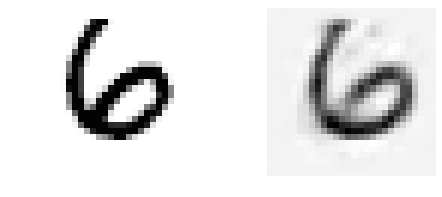

In [61]:
idx = random.randint(0, mnist.test.num_examples)
show_reconstructed_digits(mnist.test.images[idx:idx+1],
                   outputs, "/tmp/my_model_sparse.ckpt")

### Aucodificadores Variacionais

Agora vamos estudar uma nova classe de auto-codificadores, os Variacionais (VAE). Ao do contrário dos que vimos até agora, os VAE são **probabilísticos** (ou seja, seus códigos são determinados por aleatoriedade mesmo depois de treinados) e **geradores** (ou seja, podem criar _novas_ instâncias _similares_ às vistas durante o treino).

Para compreendermos esse autocodificador vamos supor que existe um espaço latente $z$, de dimensão menor que o espaço de entradas $x$, capaz de representar o espaço $x$ com o mínimo de informação redundante. Seja $p(z)$ a distribuição anterior (_prior_) do espaço latente $z$, ou seja, nosso conhecimento prévio sobre $z$ (que em nosso caso é assumir $z$ como uma variável com distribuição Gaussiana). A figura abaixo ilustra a ideia deste autocodificador. 

<img src="images/vaegaussian.png" alt="Variational Autoencoder" style="width: 400px;"/>

Nele, o codificador (uma rede neural com pesos e bias $\phi$) mapeia entradas $x$ para a distribuição posterior $q_\phi(z|x)$ sobre o espaço latente $z$ (note que a dimensão de $z$ é muito menor que a de $x$ e $q_\phi(z|x)$ é uma aproximação Gaussiana de $p(z|x)$). Ou seja, as saídas do decodificador são os parâmetros da distribuição $q_\phi(z|x)$ e, portanto, $z$ é um espaço estocástico. Como esta distribuição é gaussiana, seus parâmetros são as médias e desvios dos eixos do espaço $z$. 

O decodificador é uma rede neural com pesos e bias $\theta$. Dados os parâmetros da distribuição $q_\phi(z|x)$, ele pode amostrar uma instância particular de $z$, para então obter uma reconstrução $\tilde{x}$ da entrada $x$, usando a distribuição posterior $p_\theta(x|z)$.

Naturalmente, este processo perde informação, uma vez que o decodificador tem que obter uma amostra de um espaço de maior dimensionalidade usando uma distribuição baseada em um espaço latente de menor dimensionalidade. _Mas quanta informação ele perde??_ Uma forma de medir isso é calcular o log-likelihood $\log p_\phi (x|z)$. Isto nos dá uma medida de quão bem o decodificador aprendeu a reconstruir uma imagem $x$ da sua representação latente $z$. Além disso, como $q_\phi(z|x)$ é uma aproximação da distribuição real $p(z)$, o ideal é que o modelo tanto reconstrua bem a entrada quanto faça isso com uma distribuição que aproxime o melhor possível $p(z)$. Dada a entrada $x_i$, isso se traduz na seguinte função de perda:

$$\ell_i(\theta, \phi) = - E_{z\sim q_\theta(z\vert x_i)}[\log p_\phi(x_i\vert z)] + D_{KL}(q_\theta(z\vert x_i) \vert\vert p(z))$$

onde o primeiro componente corresponde à capacidade de reconstruir corretamente a entrada (ou seja, o quão bem o decodificador obtem a entrada $x_i$, dado $z$ -- note que, embora assustador em príncipio, esse termo correspondeà entropia cruzada) e o segundo componente corresponde à diferença entre as distribuições $q_{\theta}$ e $p$, estimada pela divergência de Kullback-Leibler.

Um problema com o VAE é que o treinamento com gradiente descendente requer que o modelo seja diferenciável com respeito aos parâmetros aprendidos, o que pressupõem que o modelo é determinístico -- uma entrada particular gera o mesmo código, dado um conjunto fixado de parâmetros. Se introduzirmos nós que fazem amostragem, o modelo se torna estocástico. Assim, a amostragem é feita por incorporar aos parâmtros do modelo um erro aleatório como entrada. Isso é chamado de _truque da reparametrização_: o modelo estima médias e desvios e, para gerar uma instância aleatória, o decodificador introduz um erro Gaussiano aleatório. Abaixo temos outra ilustração que mostra isso no VAE (do livro _Handson Machine Learning with Scikit-Learn and Tensorflow_). 

<img src="images/vae.png" alt="Variational Autoencoder" style="width: 500px;"/>

Como podemos ver, temos um autocodificador com duas camadas ocultas (vermelha e azul). A camada 2, contudo, não produz diretamente o código, mas sim a média $\mu$ e um desvio $\sigma$ do espaço latente $z$ (o espaço de codificação). Os códigos que serão usados devem ser _amostrados_ da distribuíção Gaussiana $\mathcal{N}(\mu, \sigma)$. Para isso basta introduzir um erro Guassiano no desvio.

O restante da rede é um decodificador como os que vimos antes. A ideia geral do processo é ilustrada na direita. De uma instância de treino no espaço de entrada, é derivado uma distribuição de códigos no espaço de códigos. Desta distribuição é amostrado um código (note que o ponto amostrado não corresponde ao centro da superfície Gaussiana, pois é uma amostra) que possibilita a reconstrução aproximada da saída. 

In [11]:
import random
from functools import partial

reset_graph()

n_inputs = 28*28
n_h1 = 500
n_h2 = 500
n_h3 = 20
n_h4 = n_h2
n_h5 = n_h1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense = partial(tf.layers.dense, activation = tf.nn.elu, 
                  kernel_initializer = initializer)
X = tf.placeholder(tf.float32, (None, n_inputs))
h1 = my_dense(X, n_h1)
h2 = my_dense(h1, n_h2)

h3_means = my_dense(h2, n_h3, activation = None)
h3_stds = my_dense(h2, n_h3, activation = None)
noise = tf.random_normal(tf.shape(h3_stds), dtype = tf.float32)
h3 = h3_means + h3_stds * noise

h4 = my_dense(h3, n_h4)
h5 = my_dense(h4, n_h5)
logits = my_dense(h5, n_outputs, activation = None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = X, 
                                                   logits = logits)
reconstruction_loss = tf.reduce_sum(xentropy)

eps = 1e-10
latent_loss = 0.5 * tf.reduce_sum(tf.square(h3_stds) + 
                                  tf.square(h3_means) - 1 - 
                                  tf.log(eps + tf.square(h3_stds)))
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

$$D_{KL} = \frac{1}{2} \sum_{i \in batch}{\sigma_i^2 + \mu_i^2 - 1 - \log \sigma_i^2}$$

In [12]:
n_epochs = 50
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_batch})
        (loss_val, 
         reconstruction_loss_val, 
         latent_loss_val) = s.run([loss, reconstruction_loss, latent_loss], 
                                  feed_dict={X: X_batch})
        print(" %2d LOSSES train: %.5f reconstruction: %.5f latent: %.5f" %
             (e, loss_val, reconstruction_loss_val, latent_loss_val))
        saver.save(s, "/tmp/my_model_variational.ckpt")

99%  0 LOSSES train: 32191.84961 reconstruction: 23554.70117 latent: 8637.14844
99%  1 LOSSES train: 31075.62109 reconstruction: 23774.21484 latent: 7301.40625
99%  2 LOSSES train: 26428.89844 reconstruction: 20809.99414 latent: 5618.90479
99%  3 LOSSES train: 28365.30469 reconstruction: 22384.83398 latent: 5980.47168
99%  4 LOSSES train: 22269.47266 reconstruction: 18837.91016 latent: 3431.56250
99%  5 LOSSES train: 27460.33594 reconstruction: 22646.94727 latent: 4813.38867
99%  6 LOSSES train: 29237.46289 reconstruction: 21333.37109 latent: 7904.09180
99%  7 LOSSES train: 22919.65625 reconstruction: 18936.80078 latent: 3982.85498
99%  8 LOSSES train: 20760.46875 reconstruction: 17367.09766 latent: 3393.37183
99%  9 LOSSES train: 17807.58203 reconstruction: 14792.32129 latent: 3015.26099
99% 10 LOSSES train: 17050.94141 reconstruction: 13916.05762 latent: 3134.88330
99% 11 LOSSES train: 16996.71875 reconstruction: 13942.76172 latent: 3053.95801
99% 12 LOSSES train: 16776.32617 reconst

Note que VAE não está preso a uma distribuição Gaussiana. De fato, diferentes distribuições podem ser melhores. A grande vantagem da interpretação aleatória do espaço de código (espaço latente) é que ela possibilita a geração de _novos_ casos. Isso permite uma nova classe de modelos e problemas: aqueles em que queremos _gerar_ instâncias a partir de exemplos.

#### Usando VAE para gerar dígitos

INFO:tensorflow:Restoring parameters from /tmp/my_model_variational.ckpt


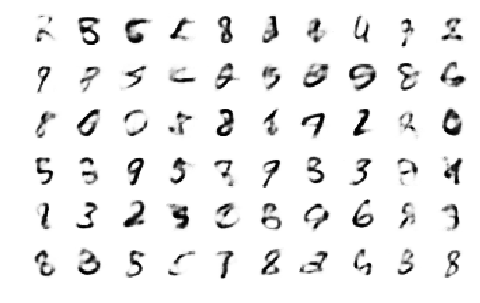

In [13]:
n_digits = 60

with tf.Session() as s:
    saver.restore(s, "/tmp/my_model_variational.ckpt")
    # random codes!
    codings_rnd = np.random.normal(size=[n_digits, n_h3])
    # decodings
    outputs_val = outputs.eval(feed_dict={h3: codings_rnd})

plt.figure(figsize=(8,50)) 
for i in range(n_digits):
    plt.subplot(n_digits, 10, i + 1)
    plot_image(outputs_val[i])

#### Usando VAE para reconstruir dígitos

In [14]:
# coding 
n_digits = 3
batch_size = 150
X_test, y_test = mnist.test.next_batch(batch_size)
with tf.Session() as s:
    saver.restore(s, "/tmp/my_model_variational.ckpt")
    codings_val = h3.eval(feed_dict={X: X_test})
    
# decoding
with tf.Session() as s:
    saver.restore(s, "/tmp/my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={h3: codings_val})

INFO:tensorflow:Restoring parameters from /tmp/my_model_variational.ckpt
INFO:tensorflow:Restoring parameters from /tmp/my_model_variational.ckpt


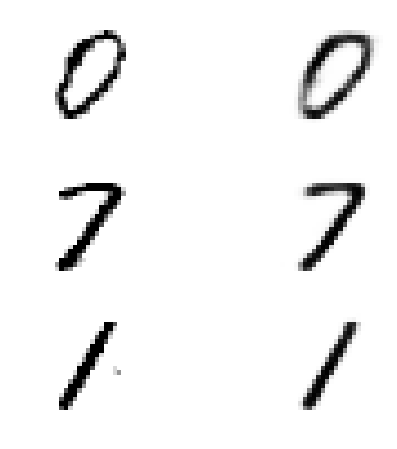

In [15]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for i in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * i)
    plot_image(X_test[i])
    plt.subplot(n_digits, 2, 2 + 2 * i)
    plot_image(outputs_val[i])

#### Usando VAE para reconstruir dígitos apartir de dígitos reais

INFO:tensorflow:Restoring parameters from /tmp/my_model_variational.ckpt


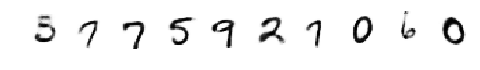

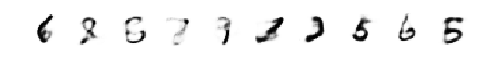

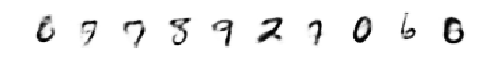

In [16]:
n_digits = 10
X_test, y_test = mnist.test.next_batch(n_digits)

with tf.Session() as s:
    saver.restore(s, "/tmp/my_model_variational.ckpt")
    # example + random
    codings_val = h3.eval(feed_dict={X: X_test})
    codings_rnd = np.random.normal(size=[n_digits, n_h3]) 
    outputs_val = outputs.eval(feed_dict={h3: codings_val}) 
    outputs_rnd = outputs.eval(feed_dict={h3: codings_rnd}) 
    outputs_val_rnd = outputs.eval(feed_dict={h3: 0.6*codings_val + 0.4*codings_rnd})

plt.figure(figsize=(8,50)) 
for i in range(n_digits):
    plt.subplot(n_digits, 10, i + 1)
    plot_image(outputs_val[i])
plt.figure(figsize=(8,50)) 
for i in range(n_digits):
    plt.subplot(n_digits, 10, i + 1)
    plot_image(outputs_rnd[i])
plt.figure(figsize=(8,50)) 
for i in range(n_digits):
    plt.subplot(n_digits, 10, i + 1)
    plot_image(outputs_val_rnd[i])

#### Observando o espaço latente

INFO:tensorflow:Restoring parameters from /tmp/my_model_variational.ckpt
Computing t-SNE embedding


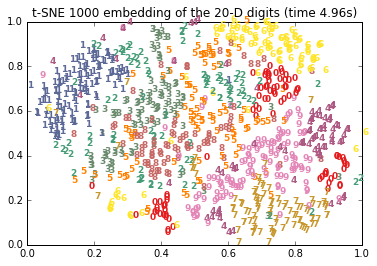

In [19]:
# coding 
cases_to_plot = 1000
idxs = np.random.permutation(mnist.test.num_examples)[:cases_to_plot]
X_test = mnist.test.images[idxs]
with tf.Session() as s:
    saver.restore(s, "/tmp/my_model_variational.ckpt")
    codings_val = h3.eval(feed_dict={X: X_test})
plot_tsne(codings_val, mnist.test.labels[idxs])

#### Interpolando dígitos com VAE

In [20]:
from numpy.linalg import norm

def linear_interpolation(p0, p1, t):
    return p0 + (p1 - p0) * t

def spherical_interpolation(p0, p1, t): # SLERP algorithm
    omega = np.arccos(np.dot(p0/norm(p0), p1/norm(p1)))
    so = np.sin(omega)
    return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

INFO:tensorflow:Restoring parameters from /tmp/my_model_variational.ckpt


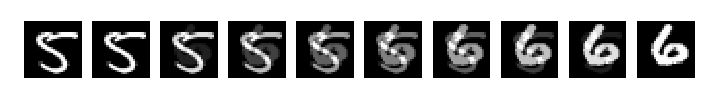

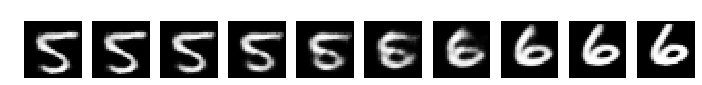

In [21]:
n_iters = 8
digits_x = []
digits_z = []

X_test, y_test = mnist.test.next_batch(2)
source_x = X_test[0]
target_x = X_test[1]

with tf.Session() as s:
    saver.restore(s, "/tmp/my_model_variational.ckpt")
    
    codings_val = h3.eval(feed_dict={X: X_test})
    outputs_val = outputs.eval(feed_dict={h3: codings_val}) 
    source_z = codings_val[0]
    target_z = codings_val[1]
        
    digits_x += [source_x.reshape(28,28)]
    digits_z += [outputs_val[0].reshape(28,28)]
    for i in range(n_iters):
        interpolated_z = linear_interpolation(source_z, target_z, i / n_iters)
        interpolated_val_z = outputs.eval(feed_dict={h3: interpolated_z.reshape(1,20)})
        digits_z += [interpolated_val_z.reshape(28,28)]
        interpolated_x = linear_interpolation(source_x, target_x, i / n_iters)
        digits_x += [interpolated_x.reshape(28,28)]
    digits_x += [target_x.reshape(28,28)]
    digits_z += [outputs_val[1].reshape(28,28)]
    
plot_figs(digits_x)
plot_figs(digits_z)

Note que além dos citados, há muitos outros tipos de auto-codificadores que merecem atenção:

* _Contractive autoencoder_ (CAE): auto-codificador é criado para reforçar a ideia de que entradas similares tenham códigos similares -- Contractive Auto-Encoders: Explicit Invariance During Feature Extraction, S. Rifai et al. (2011).
* _Stacked convolutional autoencoder_: apredem a extrair atributos visuais por reconstruir imagens processadas por camadas de convolução.
* _Generative stochastic network_ (GSN): generalização da ideia de autocodificadores robustos a ruidos extendidos para gerar dados.
* _Winner-take-all (WTA) autoencoder_: um autocodificador esparso que obtem esparsidade por permitie que apeans k% das maiores ativaçãoes sejam preservadas durante o treino (as outras são zeradas).
* _Adversarial autoencoder_: uma rede é treinada para reproduzir sua saída enquanto outra é treinada para achar entradas que a primeira nao consegue reconstruir direito. Ao fim do treino, a primeira rede se torna muito robusta.

Material baseado no de de Aurélian Géron (_Handson Machine Learning with Scikit-learn and Tensorflow_), de Jaan Altosaar (https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) e de Miriam Shiffman (http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html).